**Importation et création du dictionnaire des classes** 

Il faudra tout d'abords commencer par importer et définir les classes utilisées

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import natsort
from functools import reduce 
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from skimage.transform import resize
import numpy as np

classes = { 
    0:"Limitation de vitesse (20km/h)",
    1:"Limitation de vitesse (30km/h)", 
    2:"Limitation de vitesse (50km/h)", 
    3:"Limitation de vitesse (60km/h)", 
    4:"Limitation de vitesse (70km/h)", 
    5:"Limitation de vitesse (80km/h)", 
    6:"Fin de limitation de vitesse (80km/h)", 
    7:"Limitation de vitesse (100km/h)", 
    8:"Limitation de vitesse (120km/h)", 
    9:"Interdiction de depasser", 
    10:"Interdiction de depasser pour vehicules > 3.5t", 
    11:"Intersection ou' vous etes prioritaire", 
    12:"Route prioritaire", 
    13:"Ceder le passage", 
    14:"Arret a' l'intersection", 
    15:"Circulation interdite", 
    16:"Acces interdit aux vehicules > 3.5t", 
    17:"Sens interdit", 
    18:"Danger", 
    19:"Virage a' gauche", 
    20:"Virage a' droite", 
    21:"Succession de virages", 
    22:"Cassis ou dos-d'ane", 
    23:"Chaussee glissante", 
    24:"Chaussee retrecie par la droite", 
    25:"Travaux en cours", 
    26:"Annonce feux", 
    27:"Passage pietons", 
    28:"Endroit frequente' par les enfants", 
    29:"Debouche' de cyclistes", 
    30:"Neige ou glace",
    31:"Passage d'animaux sauvages", 
    32:"Fin des interdictions precedemment signalees", 
    33:"Direction obligatoire a' la prochaine intersection : a' droite", 
    34:"Direction obligatoire a' la prochaine intersection : a' gauche", 
    35:"Direction obligatoire a' la prochaine intersection : tout droit", 
    36:"Direction obligatoire a' la prochaine intersection : tout droit ou a' droite", 
    37:"Direction obligatoire a' la prochaine intersection : tout droit ou a' gauche", 
    38:"Contournement obligatoire de l'obstacle par la droite", 
    39:"Contournement obligatoire de l'obstacle par la gauche", 
    40:"Carrefour giratoire", 
    41:"Fin d'interdiction de depasser", 
    42:"Fin d'interdiction de depasser pour vehicules > 3.5t" 
}

**Préparation des données**
 
Les datasets d'entrainement/validation seront préparés à l'aide de ImageFolder car les données sont organisées correctement pour cette fonction de création de Dataset.   
 
Etant donné que les images passées aux modèles ont des tailles différentes, il est nécessaire d'appliquer à chaque fois une transformation pour transformer les images en tenseurs de taille 32x32, ce qui correspond aux dimensions d'input du modèle.  
 
De plus, ImageFolder associe les labels aux noms des dossiers à l'aide d'un dictionnaire, il faudra donc appliquer une transformation sur ces nouveaux labels afin de restaurer les labels originaux.  
   
Un split est effectué sur le dataset d'ImageFolder initial afin d'obtenir un ensemble d'entraînement et un ensemble de validation avec une répartition 80/20. Le dataset de validation ne sera jamais utilisé pour s'entraîner et servira uniquement à juger les performances du modèle lors de son entraînement.
 
Une fois ces deux nouveaux datasets créés, il seront chacuns chargés dans un DataLoader. La taille des batchs du loader d'entraînement seront légèrement plus petites afin d'éviter de passer des batchs trop gros lors de l'entraînement, et ces batchs seront shuffle afin d'éviter que le modèle apprend toujours sur les données dans le même ordre.

In [3]:
#Resize images to 32x32
trans = torchvision.transforms.Compose([
        torchvision.transforms.Resize((32,32)),
        torchvision.transforms.ToTensor()
    ])

#Path to Dataset
trainData = torchvision.datasets.ImageFolder("panneaux_route/Train", transform=trans)

#Restore original labels
trainData.target_transform = lambda id: int(trainData.classes[id])

#Division du dataset en train et validation
trainSize = int(0.8 * len(trainData))
validationSize = len(trainData) - trainSize
trainDataset, validationDataset = random_split(trainData, [trainSize, validationSize])
print("Train dataset length size :",len(trainData))
print("Train dataset length size :",len(validationDataset))

#Chargement dans un dataloader
trainLoader = DataLoader(trainDataset, batch_size=256, shuffle=True)
validationLoader = DataLoader(validationDataset, batch_size=1024)

Train dataset length size : 39210
Train dataset length size : 7842


**Création et choix du modèle**
 
Le modèle utilisé est similaire à celui du TP8 et est basé sur LeNet5.  
   
Le modèle implémente les fonctionnalitées suivantes :  
 - Dropout (0.5)  
 - Batch Normalisation(0.0002)  
 
Ces deux méthodes permettent de réduire l'overfitting, ce qui améliore légerement la précision sur l'ensemble de validation et de test. Le gain le plus conséquent est celui apporté par le dropout avec environ 3-4% de gain en précision.  
 
Des couches supplémentaires de convolutions ont été ajoutées comme sur le TP8 afin d'augmenter la complexité du modèle sans modifier les dimensions d'entrées ou de sortie des couches intermédiaires.  

In [4]:

class LeNet5(nn.Module):
    def __init__(self,dropout_p=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3))    
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3))
        self.dropout1 = nn.Dropout(p=dropout_p)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))    
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3)) 
        self.dropout2 = nn.Dropout(p=dropout_p)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=(3, 3))    
        self.conv6 = nn.Conv2d(128, 128, kernel_size=(3, 3)) 
        self.dropout3 = nn.Dropout(p=dropout_p)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128, 256)
        self.batchnorm4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 43)

    def forward(self, input):
        layer1 = F.relu(self.conv1(input))                  
        layer2 = F.relu(self.conv2(layer1))
        layer3 = F.max_pool2d(layer2, kernel_size=2, stride=2)
        layer3_d = self.dropout1(layer3)
        layer3_db = self.batchnorm1(layer3_d)
        layer4 = F.relu(self.conv3(layer3_db))                  
        layer5 = F.relu(self.conv4(layer4))            
        layer6 = F.max_pool2d(layer5, kernel_size=2, stride=2)
        layer6_d = self.dropout2(layer6)
        layer6_db = self.batchnorm2(layer6_d)
        layer7 = F.relu(self.conv5(layer6_db))                  
        layer8 = F.relu(self.conv6(layer7))
        layer8_d = self.dropout3(layer8)     
        layer8_db = self.batchnorm3(layer8_d)       
        layer9 = F.relu(self.fc1(torch.flatten(layer8_db,1)))  
        layer9_b = self.batchnorm4(layer9)
        layer10 = self.fc2(layer9_b)                        
        return layer10


mainModel = LeNet5(dropout_p=0.5)

**Nombre de paramètres du modèle**  
  
La complexité du modèle reste raisonnable et celui-ci prend environ 40-50s pour finir de s'entraîner sur une epoch.

In [5]:
total_nb_par = 0
for p in mainModel.parameters():
    print(p.shape)
    total_nb_par += reduce(lambda x, y: x*y, p.shape, 1)
print("total nb parameters: ", total_nb_par)

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([43, 256])
torch.Size([43])
total nb parameters:  332043


**Boucle d'entraînement**

Notre boucle d'entraînement utilise une descente de gradient stochastique avec mini batch et implémente les fonctionnalitées suivantes :  
 - Weight decay (0.0002)  
 - Sauvegarde de la meilleure itération  
 
La valeur du weight decay à été choisie en utilisant plusieurs valeurs différentes et en gardant celle qui apportait la meilleure précision sur l'ensemble de test.  
  
La sauvegarde de la meilleure itération remplace ici l'utilisation de l'early stop. A la fin de chaque epoch, la boucle d'entraînement sauvegarde les poids avec la meilleure précision sur l'ensemble de validation. Cette précision est obtenue à l'aide de notre fonction "validate", qui permet d'obtenir le score du modèle sur nos ensemble d'entraînement et de validation.  

  


In [6]:
def train_loop(train_loader, model, loss_map, lr=1e-3, epochs=20, weight_decay=0.0):
    # use gpu if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # create optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    history=[]

    bestModel = mainModel.state_dict()
    bestValidationAcc = 0
    # Train model
    model.train() 
    for epoch in range(epochs):
        loss_epoch = 0.
        previousTime = time.time()
        for images, labels in train_loader:
            # Transfers data to GPU
            images, labels = images.to(device), labels.to(device)
            # Primal computation
            output = model(images)            
            loss = loss_map(output, labels)            
            # Gradient computation
            model.zero_grad()
            loss.backward()
            # perform parameter update based on current gradients
            optimizer.step()
            # compute the epoch training loss
            loss_epoch += loss.item()
        # display the epoch training loss
        currentTime = time.time()

        validationAccuracy = round(validate(validationLoader, model).item(),3)
        trainingAccuracy = round(validate(train_loader, model).item(),3)

        history.append({"epoch" : epoch, "loss" : loss_epoch, "train_acc" : trainingAccuracy, "val_acc" : validationAccuracy})
        print(f"epoch : {epoch + 1}/{epochs}, loss = {loss_epoch:.6f}, validation_accuracy = {validationAccuracy}% , train_accuracy = {trainingAccuracy}%, epoch_time = {(currentTime - previousTime):.1f}s, time_remaining = {((currentTime - previousTime)*(epochs - epoch)):.1f}s")
        if(validationAccuracy > bestValidationAcc):
            bestModel = mainModel.state_dict()
            bestValidationAcc = validationAccuracy
            print(f"New best model with {validationAccuracy}% accuracy on validation set !")
    
    mainModel.load_state_dict(bestModel)
        
    return history
    
def show_history(history):
    figure, axis = plt.subplots(1, 2)
    axis[0].plot([d["epoch"] for d in history], [d["loss"] for d in history])
    axis[0].set_title("Loss per epoch")

    axis[1].plot([d["epoch"] for d in history], [d["train_acc"] for d in history], label="train")
    axis[1].plot([d["epoch"] for d in history], [d["val_acc"] for d in history], label="validation")
    axis[1].set_title("Accuracy per epoch")
 
    plt.legend() 
    plt.show() 
     
#Renvoie le taux de réussite d'un model sur un dataloader contenant un tuple (images,labels)         
def validate(data_loader, model):
    nb_errors = 0
    nb_tests = 0
    device = next(model.parameters()).device # current model device
    model.eval()
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device) # move data same model device
        output = model(images)
        nb_errors += ((output.argmax(1)) != labels).sum()
        nb_tests += len(images)
    
    return torch.div((100*(nb_tests-nb_errors)),nb_tests)


**Execution**
 
Le modèle charge automatiquement un ensemble de poids déjà existant nommé "modelWeights" si celui-ci existe.
Dans ce cas là, le modèle ne s'entraîne pas. Dans le cas contraire, celui-ci lance la boucle d'entraînement puis sauvegarde sur disque les poids obtenus après l'entraînement.
 
Le nombre d'epochs utilisé reste raisonnable ici, mais il serait potentiellement possible d'améliorer encore la précision du modèle avec plus de temps étant donné que l'on sauvegarde toujours la meilleure itération lors de l'entraînement.
  
Après entraînement, on arrive a environ 99.5% de précision sur l'ensemble de validation

Fnn before learning, accuracy = 3.672532558441162%
epoch : 1/15, loss = 379.696723, validation_accuracy = 51.734% , train_accuracy = 51.973%, epoch_time = 48.8s, time_remaining = 732.3s
New best model with 51.734% accuracy on validation set !
epoch : 2/15, loss = 53.924402, validation_accuracy = 97.054% , train_accuracy = 97.59%, epoch_time = 43.6s, time_remaining = 610.8s
New best model with 97.054% accuracy on validation set !
epoch : 3/15, loss = 8.542366, validation_accuracy = 98.75% , train_accuracy = 99.334%, epoch_time = 43.7s, time_remaining = 568.4s
New best model with 98.75% accuracy on validation set !
epoch : 4/15, loss = 3.599239, validation_accuracy = 98.648% , train_accuracy = 99.321%, epoch_time = 46.5s, time_remaining = 558.4s
epoch : 5/15, loss = 2.897272, validation_accuracy = 98.623% , train_accuracy = 99.509%, epoch_time = 45.4s, time_remaining = 499.2s
epoch : 6/15, loss = 1.089940, validation_accuracy = 99.171% , train_accuracy = 99.866%, epoch_time = 45.8s, time

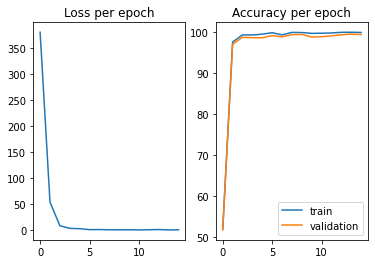

Fnn after learning, accuracy = 99.4261703491211%
Saving model


In [7]:
if(os.path.exists("modelWeights")):   
    mainModel.load_state_dict(torch.load("modelWeights"))
    print("Weights already exists")
    print(f"Accuracy = {validate(validationLoader, mainModel)}%")
    
else:
    print(f"Fnn before learning, accuracy = {validate(validationLoader, mainModel)}%")
    history=train_loop(
        train_loader=trainLoader, 
        model=mainModel, 
        loss_map=nn.CrossEntropyLoss(),
        lr=0.0005,
        epochs=15,
        weight_decay=0.0002)
    show_history(history)
    print(f"Fnn after learning, accuracy = {validate(validationLoader, mainModel)}%")

    print("Saving model")
    torch.save(mainModel.state_dict(), "modelWeights")

**Exploitation du modèle entraîné**  
 
Une fois le modèle entraîné, il nous faudra ajouter des fonctions permettant d'exploiter celui-ci facilement en traitant les images passées en entrée et en retournant directement la prédiction.  
 
La fonction predictFolder permet de passer au modèle toutes les images contenues dans le dossier passé en argument.  
Afin d'éviter les problèmes de mémoire si le dossier contient trop d'images, il faudra créer un dataLoader pour passer des batchs d'image. Ce dataLoader se basera sur une Dataset custom simple servant à récupérer l'ensemble des images dans le dossier.  
 
La fonction predictImage donne simplement l'image passée en argument au modèle et renvoie la prédiction de celui-ci.


In [ ]:
#Renvoie la prédiction de model sur un tenseur contenant l'image à prédire
def predict(imageTensor, model):
    model.eval() 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    imageTensor = imageTensor.to(device)
    return model(imageTensor.view(-1,3,32,32)).argmax(1)

def predictFolder(path):

    #Dataset used for test data
    class basicFolderDataset(Dataset):
        def __init__(self, main_dir, transform):
            self.main_dir = main_dir
            self.transform = transform
            self.list = []
            for file in os.listdir(main_dir):
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):#All supported image formats here
                    self.list.append(file)
            self.list = natsort.natsorted(self.list)

        def __len__(self):
            return len(self.list)

        def __getitem__(self, idx):
            img_loc = os.path.join(self.main_dir, self.list[idx])
            image = Image.open(img_loc).convert("RGB")
            tensor_image = self.transform(image)
            return tensor_image

    load = DataLoader(basicFolderDataset(path, transform=trans), batch_size=1024)
    tens = None
    for batch in load:
        if tens is None:
            tens = predict(batch,mainModel)
        else:
            tens = torch.cat((tens,predict(batch,mainModel)),0)
    return tens

def predictImage(path):
    return predict(trans(Image.open(path).convert("RGB")),mainModel).item()

**Prédictions réelle**
 
Les fonctions précédentes vont donc nous permettre de tester notre modèle sur l'ensemble de test. Afin de comparer les résultats de nos prédictions avec les labels donnés dans Test.csv, on va créer nous même un fichier Results.csv contenant l'ensemble des labels donnés par predictFolder.
 
Après entraînement, notre modèle peut espérer un taux de réussite d'environ 96.5% sur l'ensemble de test.
La comparaison est faite à l'aide de pandas en se basant sur le fichier de résultats créé et le fichier .csv contenant les labels des tests


In [8]:

print("Now predicting Test set")

f = open("Results.csv","w")

f.write("class, translated\n")
res = predictFolder("panneaux_route/Test")
for i in res:
    f.write(str(i.item())+","+classes.get(i.item())+"\n")
f.close()

results = pd.read_csv("Results.csv")['class']
labels = pd.read_csv("panneaux_route/Test.csv")['ClassId']

correct = 0
total = 0

for i in range(len(results)):
    if(results[i] == labels[i]):
        correct += 1
    total += 1

print("Correct =",correct,"| Total =",total,"|",(correct/total)*100,"%")

Now predicting Test set
Correct = 12192 | Total = 12630 | 96.53206650831353 %


In [9]:
print(predictImage("panneau.jpg"))
print(classes.get(predictImage("panneau.jpg")))

1
Limitation de vitesse (30km/h)


**Observations**

On peut remarquer que la plupart des images dans le dataset d'entraînement proviennent d'une seule et même image ayant été légèrement modifiée. Par exemple, les 8 premières images pour les panneaux de label 0 sont les suivantes :  
  
![](panneaux_route/Train/0/00000_00000_00000.png) ![](panneaux_route/Train/0/00000_00000_00001.png) ![](panneaux_route/Train/0/00000_00000_00002.png) ![](panneaux_route/Train/0/00000_00000_00003.png) ![](panneaux_route/Train/0/00000_00000_00004.png) ![](panneaux_route/Train/0/00000_00000_00005.png) ![](panneaux_route/Train/0/00000_00000_00006.png) ![](panneaux_route/Train/0/00000_00000_00007.png)  
  
Évidemment, effectuer une telle transformation directement sur les données initiales provoque quelques problèmes. Il devient très difficile d'éviter l'overfitting, étant donné qu'il est pratiquement inévitable qu'une image de l'ensemble de validation ne soit pas basée sur une image existant aussi dans l'ensemble d'entraînement. De ce fait, nos performances sur l'ensemble de validation ne sont pas vraiment indicatives de nos performances réelles, ici, nous sommes à 99.5% de précision sur l'ensemble de validation, mais seulement 96.5% sur un test réel.  
  
Il serait donc intéressant d'aller voir sur quels panneaux notre modèle à donc des difficultées, par exemple, les 5 premières mauvaises prédiction de notre modèle sur l'ensemble de Test sont les suivantes :  

<img src='panneaux_route/Test/00012.png' width="80" height="80">
<img src='panneaux_route/Test/00039.png' width="80" height="80">
<img src='panneaux_route/Test/00044.png' width="80" height="80">
<img src='panneaux_route/Test/00049.png' width="80" height="80">
<img src='panneaux_route/Test/00050.png' width="80" height="80">

Et voici donc la prédiction de notre modèle pour chacun de ces panneaux :

- **Neige ou glace** au lieu de **Chaussee glissante**
- **Limitation de vitesse (60km/h)** au lieu de **Limitation de vitesse (120km/h)**
- **Endroit frequente' par les enfants** au lieu de **Chaussee retrecie par la droite**
- **Limitation de vitesse (20km/h)** au lieu de **Limitation de vitesse (120km/h)**
- **Passage d'animaux sauvages** au lieu de **Travaux en cours**

![](panneaux_route/Meta/30.png) ![](panneaux_route/Meta/3.png) ![](panneaux_route/Meta/28.png) ![](panneaux_route/Meta/0.png) ![](panneaux_route/Meta/31.png)
  
Comme on peut le constater, pour chaque erreur, les panneaux partagent beaucoup de traits communs.  
De plus, le fait d'orienter ou d'avoir une résolution trop faible diminue aussi grandement le taux de réussite de notre modèle.